In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
import datetime
import pickle
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm, probplot
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from arch.unitroot import VarianceRatio
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller 
from scipy.stats import genpareto
from sklearn.utils import resample
from scipy.optimize import minimize
from scipy.special import expit, logit
from sklearn.linear_model import LogisticRegression
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from scipy.optimize import minimize
from scipy.stats import genpareto
from scipy.optimize import differential_evolution
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from scipy.optimize import differential_evolution
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Data Pre-process

### SPY

#### Generate daily returns

In [2]:
TICKER = 'SPY'
extension = 'csv'
directory_path = '/Users/xiaoyuxu/Desktop/Dissertation-docts/MSFT-Dataset/2019-2021'

# Get the list of CSV files in the directory
dir_paths = os.listdir(directory_path)
csv_file_list = []

# Iterate through the directory paths and add full paths to the csv_file_list
for dir_path in dir_paths:
    file_path = os.path.join(directory_path, dir_path)
    if file_path.endswith(f'.{extension}'):
        csv_file_list.append(file_path)

# Filter the CSV files to get orderbook files
csv_orderbook = [name for name in csv_file_list if 'orderbook' in name]
df_closing_prices = pd.DataFrame()

for orderbook_name in csv_orderbook:

    #read the orderbook. keep a record of problematic files
    try:
        df_orderbook = pd.read_csv(orderbook_name, header= None)
    except:
        print('the following file has been skipped:  ' + orderbook_name)
        continue
    
    # ask/bid price/volumns
    df_orderbook.columns = ("ASKp1" , "ASKs1" , "BIDp1",  "BIDs1")

    #get date first
    match = re.findall('\d{4}-\d{2}-\d{2}', orderbook_name)[-1]
    date = datetime.datetime.strptime(match, '%Y-%m-%d')
    
    # compute the closing price
    closing_price = (df_orderbook['ASKp1'].iloc[-1] * df_orderbook['ASKs1'].iloc[-1] + df_orderbook['BIDp1'].iloc[-1] * df_orderbook['BIDs1'].iloc[-1]) / (df_orderbook['ASKs1'].iloc[-1] + df_orderbook['BIDs1'].iloc[-1])
    df_closing_price = pd.DataFrame(data = [closing_price], index = pd.Series(date))
    df_closing_prices = df_closing_prices.append(df_closing_price)
    
#compute daily log returns
log_returns = (np.log(df_closing_prices)).diff(1).drop(df_closing_prices.index[0])
log_returns.sort_index(inplace=True)

#save
output_name = os.path.join('/Users/xiaoyuxu/Desktop/Dissertation-docts/MSFT-Dataset', TICKER +'_daily_log_returns' + '.csv')
log_returns.to_csv(output_name, header = False)

log_returns.sort_index(inplace=True)
df_closing_prices.sort_index(inplace=True)
log_returns.rename(columns={0:'return'},inplace=True)
spy_day_return=log_returns.copy()

the following file has been skipped:  /Users/xiaoyuxu/Desktop/Dissertation-docts/MSFT-Dataset/2019-2021/MSFT_2021-01-12_34200000_57600000_orderbook_1.csv


In [46]:
spy_day_return.to_csv('spy_day_return.csv', index=True)

#### Generate minute level returns

In [3]:
nmin = 1
extension = 'csv'
directory_path = '/Users/xiaoyuxu/Desktop/Dissertation-docts/MSFT-Dataset/2019-2021'
save_directory_path = '/Users/xiaoyuxu/Desktop/Dissertation-docts/MSFT-Dataset/Minutes-Dataset'
TICKER = 'SPY'  # Assuming TICKER is 'SPY'
dir_paths = os.listdir(directory_path)

csv_file_list = [os.path.join(directory_path, file) for file in dir_paths if file.endswith('.csv')]
csv_orderbook = [name for name in csv_file_list if 'orderbook' in name]
csv_message = [name for name in csv_file_list if 'message' in name]

orderbook_with_problems = []
messages_with_problems = []
opening_closing_times = []
empty_time_intervals = []

log_returns_full = pd.DataFrame()
df_microprices_full = pd.DataFrame()
for orderbook_name in csv_orderbook:
    # Read the orderbook. Keep a record of problematic files
    try:
        df_orderbook = pd.read_csv(orderbook_name, header=None)
    except Exception as e:
        orderbook_with_problems.append(orderbook_name)
        print('The following file has been skipped: ' + orderbook_name)
        continue

    df_orderbook.columns = ("ASKp1", "ASKs1", "BIDp1", "BIDs1")

    # Get date first
    match = re.findall(r'\d{4}-\d{2}-\d{2}', orderbook_name)[-1]
    date = datetime.datetime.strptime(match, '%Y-%m-%d')

    # Read times from message file. Keep a record of problematic files
    message_name = orderbook_name.replace('orderbook', 'message')
    try:
        df_message = pd.read_csv(message_name, usecols=[0], header=None)
    except Exception as e:
        messages_with_problems.append(message_name)
        print('The following file has been skipped: ' + message_name)
        continue

    market_open = int(df_message.iloc[0] / 60) / 60  # Open at minute before first transaction
    market_close = (int(df_message.iloc[-1] / 60) + 1) / 60  # Close at minute after last transaction

    # Check that the two df have the same length
    assert len(df_message) == len(df_orderbook)

    # Convert df_message.index to seconds since midnight and add this to the current date
    seconds_since_midnight = pd.to_timedelta(df_message[0], unit='S', errors="coerce")
    timeindex_ = seconds_since_midnight.values + pd.Series(date).repeat(repeats=len(seconds_since_midnight))

    # Find the index of the last order in every n-minute batch (resampling) and select the appropriate Bid-Ask prices and sizes from the orderbook
    df_indicestokeep = pd.DataFrame(range(len(df_message[0])), timeindex_)
    df_indices = df_indicestokeep.resample(f'{nmin}min', closed='right').max()
    # Keep track of the number of empty time intervals (on days that have at least one)
    if int(df_indices.isna().sum()) > 0:
        empty_time_intervals.append(f"{str(date)} : {int(df_indices.isna().sum())}")
    # Add opening prices and fill in empty time intervals with preceding price
    indices = [0] + list(df_indices.ffill()[0])
    # Reduce orderbook to relevant equidistant data (convert to numeric)
    df_orderbook_nmin = df_orderbook.iloc[indices]
    df_orderbook_nmin = df_orderbook_nmin.apply(pd.to_numeric)

    # Compute the n-min equidistant microprices
    df_microprices = (df_orderbook_nmin['ASKp1'] * df_orderbook_nmin['ASKs1'] + df_orderbook_nmin['BIDp1'] * df_orderbook_nmin['BIDs1']) / (df_orderbook_nmin['ASKs1'] + df_orderbook_nmin['BIDs1'])

    # Label microprices with the appropriate time index and drop values outside of market hours
    market_open_minutes = range(int(market_open * 60), int(market_close * 60) + nmin, nmin)
    df_microprices.index = pd.to_timedelta(market_open_minutes, unit='m') + pd.Series(date).repeat(repeats=len(market_open_minutes))
    df_microprices = df_microprices.between_time(datetime.time(9, 30), datetime.time(16))

    # Keep track of market opening and closing time if it's not 9:30 - 16:00
    if not (market_open == 9.5 and market_close == 16):
        opening_closing_times.append(f"{str(df_microprices.index[0])} - {str(df_microprices.index[-1])}")

    # Compute n-min log returns
    log_returns_nmin = np.log(df_microprices).diff(1).drop(df_microprices.index[0])
    log_returns_nmin.sort_index(inplace=True)

    # Save the file to the desired directory
    output_name = os.path.join(save_directory_path, f"{nmin}min_{str(date.date())}.csv")
    log_returns_nmin.to_csv(output_name, header=False)
    # Append log_returns_nmin to log_returns_full
    log_returns_full = pd.concat([log_returns_full, log_returns_nmin])
    # Append df_microprices to df_microprices_full
    df_microprices_full = pd.concat([df_microprices_full, df_microprices])

# Create supplementary path directories if they do not exist
supplementary_path = os.path.join('/Users/xiaoyuxu/Desktop/Dissertation-docts/MSFT-Dataset', TICKER + '_supplementary_files')
os.makedirs(supplementary_path, exist_ok=True)

skipped_files_path = os.path.join(supplementary_path, f"{nmin}min_skipped")
os.makedirs(os.path.dirname(skipped_files_path), exist_ok=True)

empty_files_path = os.path.join(supplementary_path, f"{nmin}min_empty_time_intervals")
os.makedirs(os.path.dirname(empty_files_path), exist_ok=True)

open_close_files_path = os.path.join(supplementary_path, f"{nmin}min_opening_closing_times")
os.makedirs(os.path.dirname(open_close_files_path), exist_ok=True)

with open(skipped_files_path + '_orderbook.txt', 'wb') as fp:
    pickle.dump(orderbook_with_problems, fp)

with open(skipped_files_path + '_messages.txt', 'wb') as fp:
    pickle.dump(messages_with_problems, fp)

with open(empty_files_path + '.txt', 'wb') as fp:
    pickle.dump(empty_time_intervals, fp)

with open(open_close_files_path + '.txt', 'wb') as fp:
    pickle.dump(opening_closing_times, fp)

print('Please check supplementary files before performing analysis')

log_returns_full.sort_index(inplace=True)
df_microprices_full.sort_index(inplace=True)
log_returns_full.rename(columns={0:'return'},inplace=True)
spy_min_return=log_returns_full.copy(）

The following file has been skipped: /Users/xiaoyuxu/Desktop/Dissertation-docts/MSFT-Dataset/2019-2021/MSFT_2021-01-12_34200000_57600000_orderbook_1.csv
Please check supplementary files before performing analysis


In [45]:
spy_min_return.to_csv('spy_min_return.csv', index=True)

In [4]:
spy_min_return[abs(spy_min_return['return']) >=0.05]

,return
2020-03-09 09:35:00,-1.685200
2020-03-09 09:36:00,0.832784
2020-03-09 09:37:00,1.055369
2020-03-09 09:46:00,0.057790
2020-03-09 09:50:00,-0.283226
2020-03-12 09:38:00,-0.451485
2020-03-12 09:40:00,0.278132
2020-03-12 09:41:00,-0.238360
2020-03-12 09:49:00,-0.126103
2020-03-12 09:51:00,0.565811


### BTC

In [5]:
btc = pd.read_csv(r'/Users/xiaoyuxu/Desktop/Dissertation-docts/bitcoin_2017_to_2023.csv').iloc[::-1]
btc.set_index(btc.columns[0], inplace=True)
btc = btc[~btc.index.duplicated(keep='first')]
btc_min_return = btc[['close']].copy()
btc_min_return['return'] = np.log(btc_min_return['close'] / btc_min_return['close'].shift(1))
btc_min_return = btc_min_return.loc['2017-01-01':'2023-12-31', ['close','return']]
btc_min_return['rolling_volatility']=btc_min_return['return'].rolling(window=60*24*5).std()

btc_min_return.index = pd.to_datetime(btc_min_return.index)
btc_day_return = btc_min_return.resample('D').last()
btc_day_return.index = btc_day_return.index.date

In [6]:
btc_day_return

,close,return,rolling_volatility
2017-08-17,4285.08,0.000000e+00,NaN
2017-08-18,4108.37,-1.709679e-03,NaN
2017-08-19,4139.98,0.000000e+00,NaN
2017-08-20,4086.29,4.208251e-03,NaN
2017-08-21,4016.00,0.000000e+00,NaN
...,...,...,...
2023-07-28,29314.14,-3.411322e-07,0.000385
2023-07-29,29352.90,0.000000e+00,0.000270
2023-07-30,29281.09,3.756761e-05,0.000266
2023-07-31,29232.25,0.000000e+00,0.000236


## EDA

### SPY

$\textbf{Stylized Facts}$

- Return series are not identically independently distributed although they show little serial correlation;

- Series of absolute or squared returns show profound serial correlation;

- Conditional expected returns are close to zero;

- Volatility appears to vary over time;

- Return-series are heavy-tailed;

- Extreme returns appear in clusters, this phenomenon is known as volatility clustering.

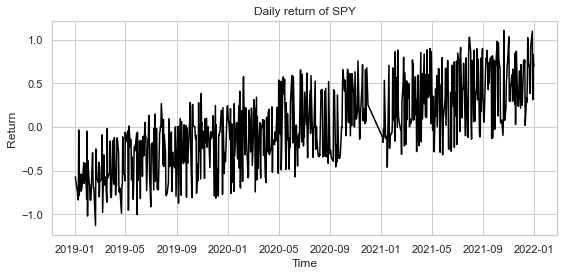

In [7]:
# Plotting returns
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")
plt.plot(spy_day_return['return'], color='black')
plt.title('Daily return of SPY')
plt.ylabel('Return')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

<Figure size 864x432 with 0 Axes>

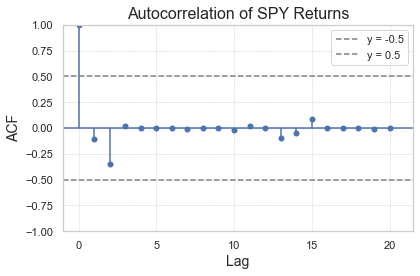

In [8]:
sns.set(style="whitegrid")
def plot_custom_acf(data, title, y1=-0.5, y2=0.5):
    plt.figure(figsize=(12, 6))
    plot_acf(data, lags=20)
    plt.axhline(y=y1, color='gray', linestyle='--', linewidth=1.5, label=f'y = {y1}')
    plt.axhline(y=y2, color='gray', linestyle='--', linewidth=1.5, label=f'y = {y2}')
    plt.title(title, fontsize=16)
    plt.xlabel('Lag', fontsize=14)
    plt.ylabel('ACF', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    
# Plot ACF for returns
plot_custom_acf(spy_min_return['return'].dropna(), 'Autocorrelation of SPY Returns')

<Figure size 864x432 with 0 Axes>

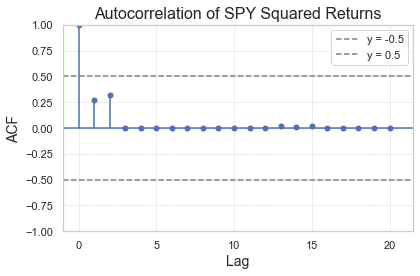

In [9]:
# Plot ACF for squared returns
plot_custom_acf(spy_min_return['return'].dropna()**2, 'Autocorrelation of SPY Squared Returns')

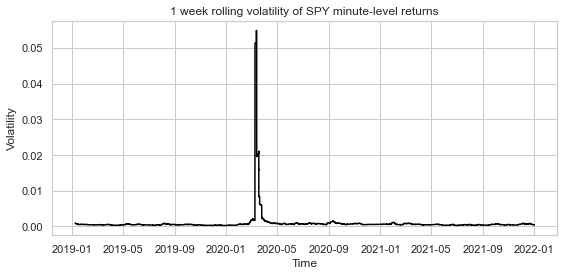

In [10]:
# Calculate 1-week (5 trading days) rolling volatility
rolling_window = 5 * 6 * 60  
spy_min_return['rolling_volatility'] = spy_min_return['return'].rolling(window=rolling_window).std()

# Plotting 1-week rolling volatility
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")
plt.plot(spy_min_return['rolling_volatility'], color='black')
plt.title('1 week rolling volatility of SPY minute-level returns')
plt.ylabel('Volatility')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

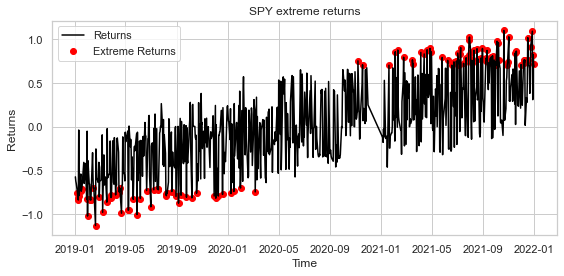

In [11]:
# Define extreme returns as returns greater than 2 standard deviations from the mean
threshold = 1.5 * spy_day_return['return'].std()
extreme_returns = spy_day_return[np.abs(spy_day_return['return']) > threshold]

# Plotting SPY extreme returns
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")
plt.plot(spy_day_return['return'], color='black', label='Returns')
plt.scatter(extreme_returns.index, extreme_returns['return'], color='red', label='Extreme Returns')
plt.title('SPY extreme returns')
plt.ylabel('Returns')
plt.xlabel('Time')
plt.legend()
plt.tight_layout()
plt.show()

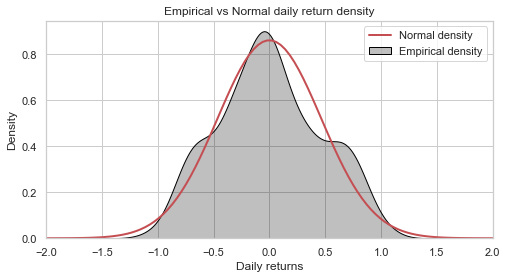

In [12]:
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")

sns.kdeplot(spy_day_return['return'], fill=True, color='black', label='Empirical density')
mean, std = spy_day_return['return'].mean(), spy_day_return['return'].std()
x = np.linspace(-2, 2, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal density')

plt.title('Empirical vs Normal daily return density')
plt.xlabel('Daily returns')
plt.ylabel('Density')
plt.legend()
plt.xlim(-2, 2)
plt.show()

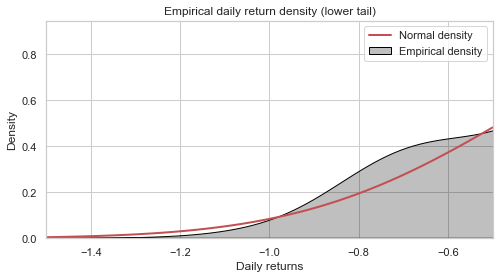

In [13]:
# Plot Empirical return density (lower tail)
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")
sns.kdeplot(spy_day_return['return'], fill=True, color='black', label='Empirical density')
plt.xlim(-1.5, -0.5)
x = np.linspace(-1.5, -0.5, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal density')
plt.title('Empirical daily return density (lower tail)')
plt.xlabel('Daily returns')
plt.ylabel('Density')
plt.legend()
plt.show()

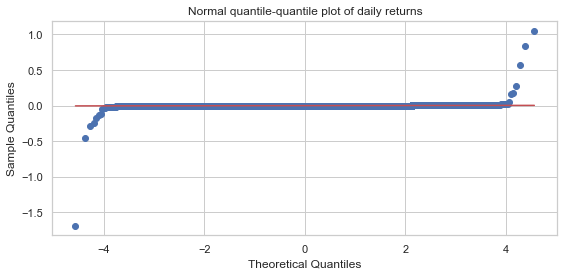

In [14]:
# Normal quantile-quantile plot of returns
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")
probplot(spy_min_return['return'], dist="norm", plot=plt)
plt.title('Normal quantile-quantile plot of daily returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.tight_layout()
plt.show()

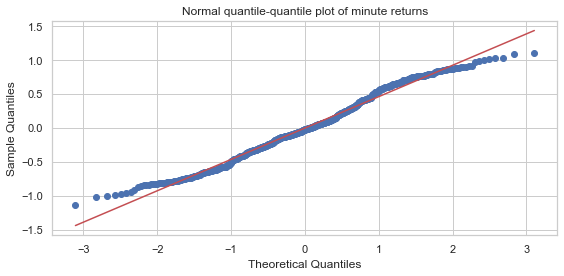

In [15]:
# Normal quantile-quantile plot of returns
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")
probplot(spy_day_return['return'], dist="norm", plot=plt)
plt.title('Normal quantile-quantile plot of minute returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.tight_layout()
plt.show()

### BTC

**Notable Events in the Crypto Market between 2018 and 2023**

- $01/2018$: Several countries, including South Korea and China, announced regulatory measures to control cryptocurrency trading and initial coin offerings (ICOs) in early 2018. 

- $07/2019$: Trump Tweets attacking cryptos.

- $10/2019$: Xi Jinping announced a pro-blockchain statement.

- $03/2020$: Peak of Covid Crisis.

- $05/2020$: The third BTC halving. 

- $09/2020$: Large scale wallet movements to exchanges.

- $12/2020$: Lawsuit against Ripple. 

- $02/2021$: Tesla announced a $1.5$ billion investment in Bitcoin and stated plans to accept Bitcoin as payment for its vehicles. 

- $09/2021$: The Chinese central bank stated that all crypto transactions are illegal, and banned in the country. 

- $04/2022$: LUNA Collapse.

- $06/2022$: Fed starts quantitative tightening.

- $12/2023$: The Conviction of Sam Bankman-Fried.

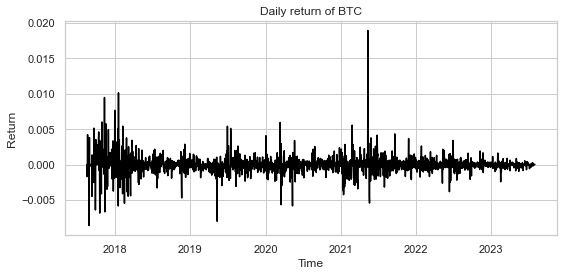

In [16]:
# Plotting returns
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")
plt.plot(btc_day_return['return'], color='black')
plt.title('Daily return of BTC')
plt.ylabel('Return')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

<Figure size 864x432 with 0 Axes>

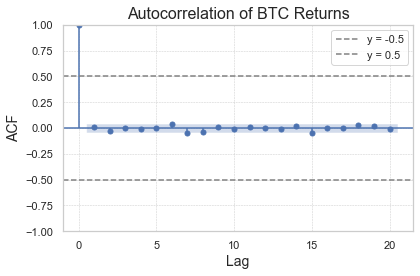

In [17]:
plot_custom_acf(btc_day_return['return'].dropna(), 'Autocorrelation of BTC Returns')

<Figure size 864x432 with 0 Axes>

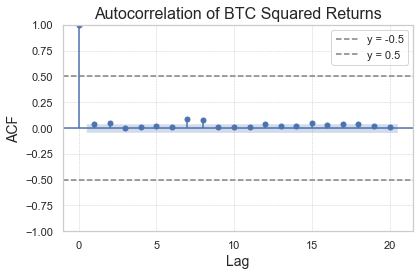

In [18]:
plot_custom_acf(btc_day_return['return'].dropna()**2, 'Autocorrelation of BTC Squared Returns')

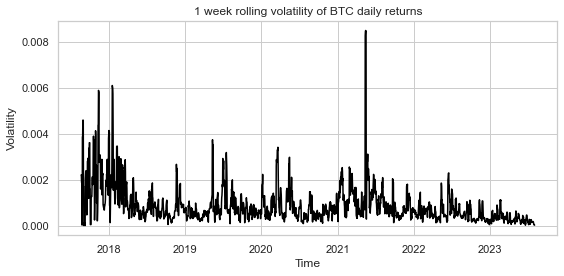

In [19]:
# Calculate 1-week (5 trading days) rolling volatility
btc_day_return['rolling_volatility'] = btc_day_return['return'].rolling(window=5).std()

# Plotting 1-week rolling volatility
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")
plt.plot(btc_day_return['rolling_volatility'], color='black')
plt.title('1 week rolling volatility of BTC daily returns')
plt.ylabel('Volatility')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

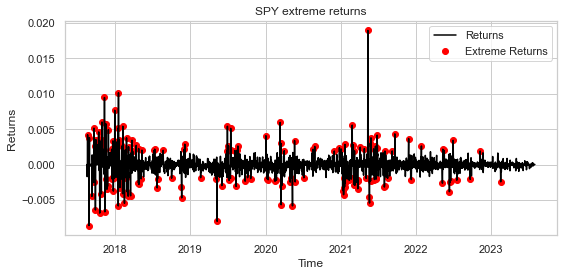

In [20]:
# Define extreme returns as returns greater than 2 standard deviations from the mean
threshold = 1.5 * btc_day_return['return'].std()
extreme_returns = btc_day_return[np.abs(btc_day_return['return']) > threshold]

# Plotting BTC extreme returns
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")
plt.plot(btc_day_return['return'], color='black', label='Returns')
plt.scatter(extreme_returns.index, extreme_returns['return'], color='red', label='Extreme Returns')
plt.title('SPY extreme returns')
plt.ylabel('Returns')
plt.xlabel('Time')
plt.legend()
plt.tight_layout()
plt.show()

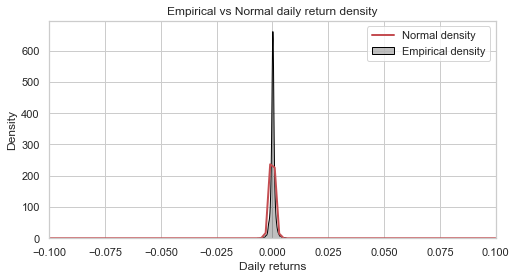

In [21]:
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")

sns.kdeplot(btc_day_return['return'], fill=True, color='black', label='Empirical density')
mean, std = btc_day_return['return'].mean(), btc_day_return['return'].std()
x = np.linspace(-0.1, 0.1, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal density')

plt.title('Empirical vs Normal daily return density')
plt.xlabel('Daily returns')
plt.ylabel('Density')
plt.legend()
plt.xlim(-0.1, 0.1)
plt.show()

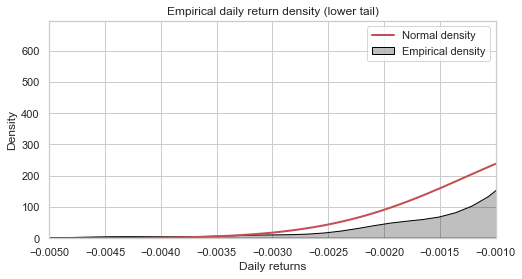

In [22]:
# Plot Empirical return density (lower tail)
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")
sns.kdeplot(btc_day_return['return'], fill=True, color='black', label='Empirical density')
plt.xlim(-0.005, -0.001)
x = np.linspace(-0.005, -0.001, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal density')
plt.title('Empirical daily return density (lower tail)')
plt.xlabel('Daily returns')
plt.ylabel('Density')
plt.legend()
plt.show()

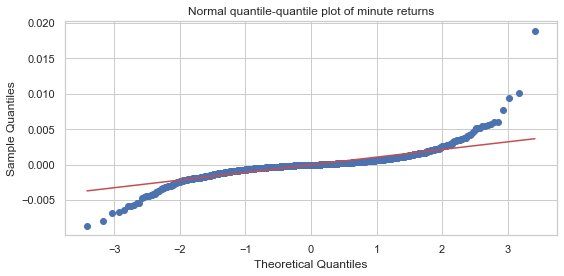

In [23]:
# Normal quantile-quantile plot of returns
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")
probplot(btc_day_return['return'], dist="norm", plot=plt)
plt.title('Normal quantile-quantile plot of minute returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.tight_layout()
plt.show()

## Validation of Efficient Market Hypothesis (EMH) on CCs

- Efficient Market Assumption:The efficient market assumption posits that asset prices fully reflect all available information, making it impossible to consistently achieve higher returns than the overall market through prediction or timing.

**Why check validation of EMH on CCs?**

$1)$ On one hand, both HAR-EVT and R-POT models that we will leverage in more detail and utilize later on requires the return follows a general Itô semimartingale process i.e. given the continuous stochastic process $(X_t)_{t \geq 0}$:

$X_t = X_0 + \int_{0}^t \tilde{\sigma}_s d W_s + (\eta \mathbb{1}_{|\eta| \leq 1}) \star (p - q)_t + (\eta \mathbb{1}_{|\eta| > 1}) \star p_t$;

s.t.

$U \star \mu_t = \int_0^t \int_{\mathbb{R}} U(\omega; t, x) \mu(\omega; d s, d x)$.

In other words, the above stochastic process can be reviewed as the following decompositions:

- A continuous martingale: $\int_{0}^t \tilde{\sigma}_s d W_s$;

- A purely discontinuous martingale of “small" jumps: $(\eta \mathbb{1}_{|\eta| \leq 1}) \star (p - q)_t$;

- A term consisting of “big" jumps: $(\eta \mathbb{1}_{|\eta| > 1}) \star p_t$.

Then the associated discrete-time return process $(Y_t)_{t \geq 0}$ can be represented as follows:

$Y_t = X_t - X_{t-1} = \int_{t-1}^t \tilde{\sigma}_s d W_s + (M_t - M_{t-1}) + (J_t - J_{t-1})$;

s.t. 

$M_t = (\eta \mathbb{1}_{|\eta| \leq 1}) \star (p - q)_t$ and $J_t = (\eta \mathbb{1}_{|\eta| > 1}) \star p_t$.

However, the EMH implies that markets are informationally efficient and thus prices follow a fair game, meaning they can be modeled as martingales or semimartingales. Therefore, before fitting the cryptocurrency asset returns into these models, we must first validate the EMH in the crypto market.

$2)$ On the other hand, previous academic research indicates time variation in market efficiency levels within the crypto market. Therefore, we aim to analyze and utilize cryptocurrency price data starting from the point at which the EMH began to be reasonably satisfied.

Based on the paper "On the Efficiency and its Drivers in the Cryptocurrency Market: The Case of Bitcoin and Ethereum," the two to three most effective models for analyzing the Efficient Market Hypothesis (EMH) for cryptocurrencies are:

- Variance Ratio Test

The Variance Ratio Test is based on the idea that if a series follows a random walk, the variance of its k-period return should be k times the variance of its one-period return. The test statistic for the Variance Ratio (VR) test is given by:

$VR(k) = \frac{\frac{1}{k} \sum_{j=1}^{k} \left( P_{t+j} - P_t \right)^2}{\frac{1}{n-1} \sum_{t=1}^{n-1} \left( P_{t+1} - P_t \right)^2}$;

s.t. the test statistic $Z(k)$ for large samples is:

$Z(k) = \frac{VR(k) - 1}{\sqrt{\frac{2(2k-1)(k-1)}{3k(nk)}}}$;

and under null hypothesis it should be approximately normally distributed.

- Autocorrelation Test

The Autocorrelation Test checks the correlation of a time series with its lagged values. The k-th order autocorrelation coefficient $\rho_k$ is given by:

$\rho_k = \frac{\sum_{t=k+1}^{n} (R_t - \bar{R})(R_{t-k} - \bar{R})}{\sum_{t=1}^{n} (R_t - \bar{R})^2}$;

s.t. the test statistic $Z(k)$ for large samples is:

$Z(\rho_k) = \frac{\rho_k}{\sqrt{\frac{1}{n}}}$

and under null hypothesis it should be approximately normally distributed.

- Rolling Window Analysis

Rolling Window Analysis involves calculating test statistics (such as the Variance Ratio and Autocorrelation) over a moving window of fixed length to detect changes in market efficiency over time. 

The rolling variance ratio for window $w$ and step $s$ is:

$VR_s(k, w) = \frac{\frac{1}{k} \sum_{j=1}^{k} \left( P_{s+j} - P_s \right)^2}{\frac{1}{w-1} \sum_{t=s}^{s+w-1} \left( P_{t+1} - P_t \right)^2}$;

The rolling autocorrelation for window $w$ and step $s$:

$\rho_s(k, w) = \frac{\sum_{t=s+k+1}^{s+w} (R_t - \bar{R_s})(R_{t-k} - \bar{R_s})}{\sum_{t=s}^{s+w} (R_t - \bar{R_s})^2}$.



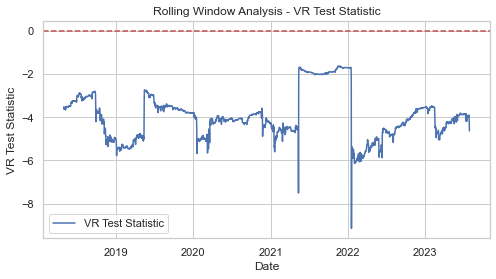

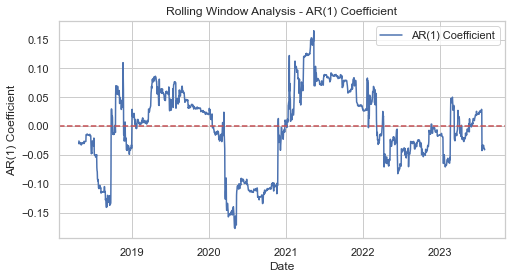

In [24]:
# Variance Ratio (VR) Test with Rolling Window

# Parameters
window_size = 252  # Rolling window size (one trading year)
step_size = 1  # Step size

vr_statistics = []

# Rolling window analysis
for start in range(0, len(btc_day_return) - window_size, step_size):
    end = start + window_size
    window_data = btc_day_return['return'].iloc[start:end].dropna()
    if len(window_data) < window_size:
        continue
    vr_test = VarianceRatio(window_data, lags=2)
    vr_statistics.append(vr_test.stat)

# Convert results to a DataFrame
vr_statistics = pd.Series(vr_statistics, index=btc_day_return.index[window_size:])

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(vr_statistics, label='VR Test Statistic')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Rolling Window Analysis - VR Test Statistic')
plt.xlabel('Date')
plt.ylabel('VR Test Statistic')
plt.legend()
plt.show()

# Autoregressive (AR) Model with Rolling Window
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency D will be used.")

ar_coefficients = []

# Rolling window analysis
for start in range(0, len(btc_day_return) - window_size, step_size):
    end = start + window_size
    window_data = btc_day_return['return'].iloc[start:end].dropna()
    if len(window_data) < window_size:
        continue
    ar_model = AutoReg(window_data, lags=1).fit()
    ar_coefficients.append(ar_model.params[1])

# Convert results to a DataFrame
ar_coefficients = pd.Series(ar_coefficients, index=btc_day_return.index[window_size:])

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(ar_coefficients, label='AR(1) Coefficient')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Rolling Window Analysis - AR(1) Coefficient')
plt.xlabel('Date')
plt.ylabel('AR(1) Coefficient')
plt.legend()
plt.show()

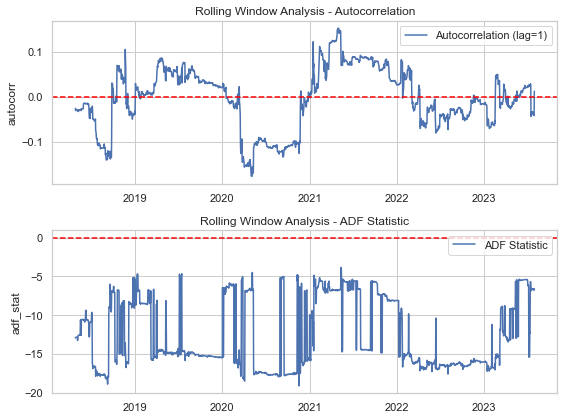

In [25]:
window = 252
# Autocorrelation
btc_day_return['autocorr'] = btc_day_return['return'].rolling(window=window).apply(lambda x: x.autocorr(lag=1))

# Augmented Dickey-Fuller test
def adf_test(timeseries):
    adf_result = adfuller(timeseries.dropna())
    return adf_result[0]  # Returning only the ADF statistic

btc_day_return['adf_stat'] = btc_day_return['return'].rolling(window=window).apply(adf_test)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot Autocorrelation
sns.lineplot(ax=axes[0], x=btc_day_return.index, y=btc_day_return['autocorr'], label='Autocorrelation (lag=1)')
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Rolling Window Analysis - Autocorrelation')

# Plot ADF Statistic
sns.lineplot(ax=axes[1], x=btc_day_return.index, y=btc_day_return['adf_stat'], label='ADF Statistic')
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Rolling Window Analysis - ADF Statistic')

plt.tight_layout()
plt.show()

- Autocorrelation: The autocorrelation values around 0 and within the range of -0.1 to 0.1 indicate that the returns of cryptocurrencies are not significantly correlated with their own past values. This low autocorrelation suggests that past returns do not predict future returns well, aligning with the Efficient Market Hypothesis (EMH). According to EMH, asset prices reflect all available information, making it difficult to profit from historical price patterns.

- ADF Statistic: The ADF statistic values around -10 and -15 indicate that the cryptocurrency returns series is likely stationary. A stationary series implies that the statistical properties of returns remain consistent over time, supporting the hypothesis that cryptocurrency prices follow a random walk. This randomness further supports the notion of market efficiency under EMH, where prices adjust quickly to new information and do not exhibit predictable patterns.

- VR Test Statistic: The VR Test Statistic values around -6 to -4 suggest that there is some degree of long-term dependence or volatility clustering in cryptocurrency returns. This indicates that while the market adjusts to new information efficiently, there may still be periods where past volatility influences future volatility.

- AR(1) Coefficient: The AR(1) Coefficient centered around 0 and within -0.15 to 0.15 suggests that past returns do not strongly predict future returns. This aligns with the idea that cryptocurrency prices follow a random walk and quickly adjust to new information, characteristic of an efficient market.

The cryptocurrency market exhibits characteristics that are generally consistent with the Efficient Market Hypothesis (EMH). While there are signs of market efficiency (low autocorrelation in AR(1)), the presence of volatility clustering (indicated by the VR Test Statistic) suggests some potential for short-term inefficiencies.

Insights: Try to develop trading strategies that capitalize on market efficiencies while managing risks associated with short-term volatility. Always implement robust risk management practices to mitigate potential losses in the volatile cryptocurrency market.

## HAR-EVT model implementation

- The HAR-EVT model is designed to capture the dynamics of financial returns using high-frequency data, while also incorporating Extreme Value Theory (EVT) to model tail risks associated with extreme market events.

**Mathematical Formulation**

$1)$ Return Process

The return process $(Y_t)_t$ is defined as:

$Y_t = \sigma_t Z_t$;

s.t. $\sigma_t = \exp{\{\beta^T R_{M, t-1}\}}$ and $Z_t \sim \mathcal{N}(0,1)$.

$2)$ Conditional Volatility Modeling

$\sigma_t^2 = \exp{\{\mathbb{E}[\log R V_t | \mathcal{F}_{t-1}]\}}$;

s.t.  $R V_t$ is the realized variance and $R_{M, t-1}$ is the vector of lagged realized measures: $\log{R V_t}$, $\log{R V_{t-w}}$, $\log{R V_{t-m}}$ and $\log{1+\hat{J}_{t-1}}$.

$3)$ Model dynamics

$R V_t$ is modeled using a HAR-J (High-Frequency-Autoregressive-Jump) specification:

$\log R V_t = \beta_0 + \beta_d \log{R V_{t-d}} + \beta_w \log{R V_{t-w}} + \beta_m \log{R V_{t-m}}+ \beta_J \log{1+\hat{J}_{t-1}}+\epsilon_t$;

with $\epsilon \sim \mathcal{N}(0, \sigma_\epsilon^2)$ and $\hat{J}_t$ being the estimator of the jump component under quadratic variation.

$4)$ Extreme Value Theory (EVT)

After fitting the HAR-EVT model, the tail risk is estimated using EVT. Standardized residuals $Z_t$ are modeled with the Generalized Pareto Distribution (GPD) above a threshold $u$:

$\mathbb{P}(- Z \geq u) = \phi$;

where $\phi$ is the exceedance probability and $-Z$ is the negative standardized residuals. 

$5)$ VaR

VaR is computed using the estimated parameters from the GPD:

$VaR_{\alpha, t| t-1}(Y) = \sigma_t u + \frac{\xi}{1-\alpha} \sigma_t \beta (\frac{\phi}{1-\alpha})^{- 1/\xi}$;

where $(\xi, \beta)$ are the parameters of the GPD and $u$ is the threshold above which extreme events are considered. 

$6)$ Bootstrap Re-sampling for inference

Due to the complexity and two-step nature of fitting the HAR-EVT model, bootstrap resampling is used to obtain confidence intervals for the tail risk parameters:

Block resampling of residuals $\{\hat{z}_t\}_{t-1}^n$; Resample 
$B$ times to obtain $B$ sets of estimates for VaR and tail parameters; Compute empirical confidence intervals from the bootstrap samples.

In [26]:
btc_min_return['logRV_t'] = btc_min_return['return'].rolling(window=24 * 60)\
                                        .apply(lambda x: np.sum(np.square(x))).apply(np.log)
btc_min_return['logRV_t-w'] =btc_min_return['return'].rolling(window=24 * 60 * 5)\
                                        .apply(lambda x: np.sum(np.square(x))).apply(np.log)
btc_min_return['logRV_t-m'] =btc_min_return['return'].rolling(window=24 * 60 * 5 * 22)\
                                        .apply(lambda x: np.sum(np.square(x))).apply(np.log)

# Estimate the jump component of quadratic variation

# Compute realized variance (RV)
btc_min_return['RV_t'] = btc_min_return['return'].rolling(window=5*24*60).apply(lambda x: np.sum(x**2))

# Define threshold u_n for truncation (e.g., 95th percentile of returns)
u_n = np.percentile(np.abs(btc_min_return['return']), 95)

# Compute truncated realized variance (TRV)
btc_min_return['TRV_t'] = btc_min_return['return'].apply(lambda x: x**2 if np.abs(x) > u_n else 0).rolling(window=5*24*60).sum()

# Calculate jump component J_t
btc_min_return['J_t'] = btc_min_return['RV_t'] - btc_min_return['TRV_t']
btc_min_return['log1+J_t'] = np.log(1 + btc_min_return['J_t'])

btc_min_return = btc_min_return.dropna()

In [27]:
# Prepare data for regression
X = btc_min_return[['logRV_t-w', 'logRV_t-m', 'logRV_t', 'log1+J_t']]
X = sm.add_constant(X)
y = btc_min_return['logRV_t']

# Fit the HAR-EVT model using OLS regression
model = sm.OLS(y, X).fit()

# Extract the fitted values for conditional volatility
btc_min_return['sigma_t^2'] = np.exp(model.fittedvalues)

# Standardize the residuals
btc_min_return['Z_t'] = btc_min_return['return'] / np.sqrt(btc_min_return['sigma_t^2'])

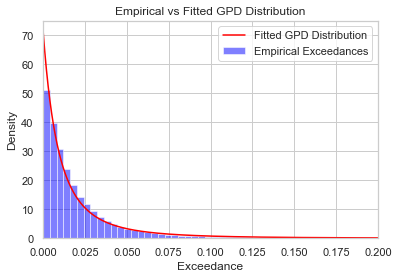

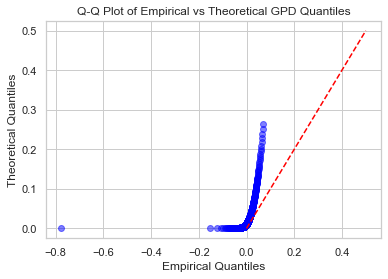

In [31]:
# Fit the GPD to the tail of negative standardized residuals

# Set the threshold for tail fitting (e.g., 95th percentile of negative Z_t)
threshold = np.percentile(-btc_min_return['Z_t'], 95)

# Fit GPD to the exceedances
exceedances = -btc_min_return['Z_t'][btc_min_return['Z_t'] < -threshold] - threshold
params = genpareto.fit(exceedances)

# Extract GPD parameters
xi, loc, beta = params

print(f"GPD parameters: xi={xi}, beta={beta}")

# Calculate VaR using the fitted GPD parameters
def compute_var(alpha, sigma_t, u, xi, beta):
    if xi != 0:
        VaR = u + (beta / xi) * ((alpha / threshold) ** (-xi) - 1)
    else:
        VaR = u + beta * np.log(alpha / threshold)
    return sigma_t * VaR

btc_min_return['VaR'] = btc_min_return.apply(lambda row: compute_var(0.95, np.sqrt(row['sigma_t^2']), threshold, xi, beta), axis=1)


# Evaluation of model performance

# VaR backtesting: compare the actual loeese during extreme events with the Var estimates provided by the model

btc_min_return['exceeds_VaR'] = btc_min_return['return'] < -btc_min_return['VaR']

num_violations = btc_min_return['exceeds_VaR'].sum()
total_obs = len(btc_min_return)
violation_rate = num_violations / total_obs

print(f"Number of violations: {num_violations}")
print(f"Violation rate (expected 5% for 95% VaR): {violation_rate}")


# Generate a range of quantiles for the theoretical GPD distribution
quantiles = np.linspace(0.0, 0.99, 1000)
theoretical_quantiles = genpareto.ppf(quantiles, xi, loc=0, scale=beta)

# Plot empirical exceedances
plt.hist(exceedances, bins=200, density=True, alpha=0.5, color='blue', label='Empirical Exceedances')

# Plot fitted GPD distribution
plt.plot(theoretical_quantiles, genpareto.pdf(theoretical_quantiles, xi, loc=0, scale=beta),
         color='red', label='Fitted GPD Distribution')

# Add labels and title
plt.xlim(0.0, 0.2)
plt.xlabel('Exceedance')
plt.ylabel('Density')
plt.title('Empirical vs Fitted GPD Distribution')
plt.legend()

# Show plot
plt.show()

# Plot empirical quantiles vs. theoretical quantiles
plt.figure(figsize=(6, 4))
plt.scatter(np.percentile(-btc_min_return['Z_t'], quantiles * 100), theoretical_quantiles, color='blue', alpha=0.5)
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='--')  # Diagonal line for reference

# Add labels and title
plt.xlabel('Empirical Quantiles')
plt.ylabel('Theoretical Quantiles')
plt.title('Q-Q Plot of Empirical vs Theoretical GPD Quantiles')

# Show plot
plt.show()

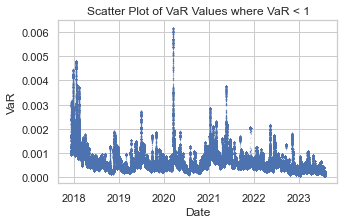

In [32]:
var_less_than_1 = btc_min_return[btc_min_return['VaR'] < 1]

# Scatter plot

plt.figure(figsize=(5, 3))
plt.scatter(var_less_than_1.index, var_less_than_1['VaR'], color='b', marker='o', s=.01, alpha=0.75)
plt.title('Scatter Plot of VaR Values where VaR < 1')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.grid(True)

plt.show()

In [33]:
# Bootstrap resampling to compute confidence intervals

# Function to compute HAR-EVT parameters
def compute_HAR_EVT(data):
    # Prepare data for regression
    X = sm.add_constant(data[['logRV_t-w', 'logRV_t-m', 'logRV_t', 'log1+J_t']])
    y = data['logRV_t']
    
    # Fit OLS model
    model = sm.OLS(y, X, missing='drop').fit()
    
    # Compute volatility estimates
    data['sigma_t^2'] = np.exp(model.fittedvalues)
    data['Z_t'] = data['return'] / np.sqrt(data['sigma_t^2'])
    
    # Compute threshold for VaR estimation
    alpha = 0.05  # Example alpha level for VaR
    threshold = np.percentile(-data['Z_t'], 95)
    
    # Fit generalized Pareto distribution to tail losses
    params = genpareto.fit(-data.loc[data['Z_t'] < -threshold, 'Z_t'])
    xi, u, beta = params
    
    # Compute VaR and ES
    data['VaR'] = u + (np.sqrt(data['sigma_t^2']) / xi) * ((1 - alpha) ** (-beta) - 1)
    data['ES'] = (u + np.sqrt(data['sigma_t^2']) / xi) / (1 - beta) * (1 - alpha) ** (-beta)
    
    return data['VaR'], data['ES'], data['sigma_t^2']

# Bootstrap parameters
bootstrap_samples = 100
var_estimates = []
es_estimates = []
volatility_estimates = []

# Perform bootstrap sampling and compute HAR-EVT estimates
for i in range(bootstrap_samples):
    # Bootstrap resample the entire dataset
    boot_data = resample(btc_min_return, replace=True, n_samples=len(btc_min_return))
    
    # Compute HAR-EVT parameters for bootstrap sample
    boot_var, boot_es, boot_volatility = compute_HAR_EVT(boot_data)
    
    # Store estimates
    var_estimates.append(boot_var)
    es_estimates.append(boot_es)
    volatility_estimates.append(boot_volatility)
    
    # Print progress
    print(f"Iteration {i + 1}/{bootstrap_samples} completed.")

# Convert to arrays
var_estimates = np.array(var_estimates)
es_estimates = np.array(es_estimates)
volatility_estimates = np.array(volatility_estimates)

# Compute mean and 95% CI
mean_var = np.mean(var_estimates, axis=0)
lower_var = np.percentile(var_estimates, 2.5, axis=0)
upper_var = np.percentile(var_estimates, 97.5, axis=0)

mean_es = np.mean(es_estimates, axis=0)
lower_es = np.percentile(es_estimates, 2.5, axis=0)
upper_es = np.percentile(es_estimates, 97.5, axis=0)

mean_volatility = np.mean(volatility_estimates, axis=0)
lower_volatility = np.percentile(volatility_estimates, 2.5, axis=0)
upper_volatility = np.percentile(volatility_estimates, 97.5, axis=0)

Iteration 1/100 completed.
Iteration 2/100 completed.
Iteration 3/100 completed.
Iteration 4/100 completed.
Iteration 5/100 completed.
Iteration 6/100 completed.
Iteration 7/100 completed.
Iteration 8/100 completed.
Iteration 9/100 completed.
Iteration 10/100 completed.
Iteration 11/100 completed.
Iteration 12/100 completed.
Iteration 13/100 completed.
Iteration 14/100 completed.
Iteration 15/100 completed.
Iteration 16/100 completed.
Iteration 17/100 completed.
Iteration 18/100 completed.
Iteration 19/100 completed.
Iteration 20/100 completed.
Iteration 21/100 completed.
Iteration 22/100 completed.
Iteration 23/100 completed.
Iteration 24/100 completed.
Iteration 25/100 completed.
Iteration 26/100 completed.
Iteration 27/100 completed.
Iteration 28/100 completed.
Iteration 29/100 completed.
Iteration 30/100 completed.
Iteration 31/100 completed.
Iteration 32/100 completed.
Iteration 33/100 completed.
Iteration 34/100 completed.
Iteration 35/100 completed.
Iteration 36/100 completed.
I

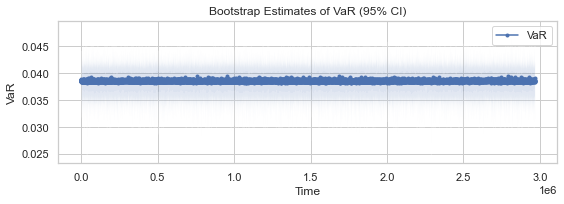

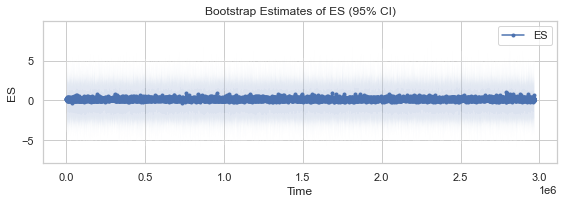

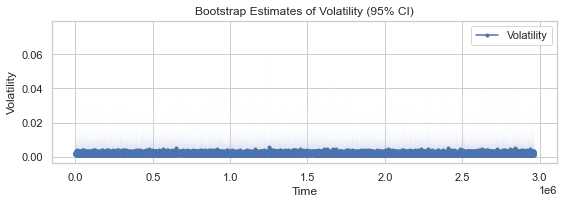

In [34]:
# Function to downsample data
def downsample_data(data, n):
    return data[::n]

# Function to plot VaR, ES, or Volatility with shaded error bands
def plot_with_errorbands(time_index, mean_values, lower_values, upper_values, ylabel, title, n):
    plt.figure(figsize=(8, 3))
    plt.plot(time_index[::n], mean_values[::n], label=ylabel, marker='o', markersize=3)
    plt.fill_between(time_index[::n], lower_values[::n], upper_values[::n], alpha=0.2)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example downsampling factor (adjust as needed)
downsample_factor = 10
time_index=range(len(mean_es))

# Downsample time_index and data arrays
time_index_downsampled = downsample_data(time_index, downsample_factor)
mean_var_downsampled = downsample_data(mean_var, downsample_factor)
lower_var_downsampled = downsample_data(lower_var, downsample_factor)
upper_var_downsampled = downsample_data(upper_var, downsample_factor)
mean_es_downsampled = downsample_data(mean_es, downsample_factor)
lower_es_downsampled = downsample_data(lower_es, downsample_factor)
upper_es_downsampled = downsample_data(upper_es, downsample_factor)
mean_volatility_downsampled = downsample_data(mean_volatility, downsample_factor)
lower_volatility_downsampled = downsample_data(lower_volatility, downsample_factor)
upper_volatility_downsampled = downsample_data(upper_volatility, downsample_factor)

# Example usage for VaR
plot_with_errorbands(time_index_downsampled, mean_var_downsampled, lower_var_downsampled, upper_var_downsampled,
                     'VaR', 'Bootstrap Estimates of VaR (95% CI)', downsample_factor)

# Example usage for ES
plot_with_errorbands(time_index_downsampled, mean_es_downsampled, lower_es_downsampled, upper_es_downsampled,
                     'ES', 'Bootstrap Estimates of ES (95% CI)', downsample_factor)

# Example usage for Volatility
plot_with_errorbands(time_index_downsampled, mean_volatility_downsampled, lower_volatility_downsampled, upper_volatility_downsampled,
                     'Volatility', 'Bootstrap Estimates of Volatility (95% CI)', downsample_factor)


- VaR: The VaR estimates are relatively stable over time, with some minor fluctuations. The confidence intervals are fairly narrow, indicating a reasonable level of precision in the VaR estimates. The upper bound of the VaR remains below 0.05, suggesting that the model captures the risk within a tight range.

- ES: The ES estimates show more variability compared to the VaR estimates. The confidence intervals are wider, particularly on the lower end, which suggests more uncertainty in the ES estimates. There are a few significant outliers where the ES dips below -10, indicating instances of extreme risk. Indeed, the presence of outliers in the ES plot highlights periods of extreme risk that the model captures.

- Volatility: The volatility estimates are consistently low, with the mean values hovering close to zero. The confidence intervals are narrow, indicating high precision in the volatility estimates. There is minimal fluctuation in the volatility estimates over time.

## R-POT (Realized Peaks-over-Threshold) model implementation

- The R-POT model is an econometric model designed to capture the extreme tails of financial return distributions. It directly models the tails using high-frequency data and realized measures. This approach allows for a more accurate and dynamic estimation of tail risks, such as Value-at-Risk (VaR).

**Mathematical Formulation**

$1)$ Calculate realized measures including realized variances and jump components;

- Daily, Weekly and Monthly Realized Variance (RV)

$RV_t^{(d)} = \sum_{i=1}^n r_{t,i}^2 \quad RV_t^{(w)} = \sum_{j=t-6}^t RV_j^{(d)} \quad RV_t^{(m)}=\sum_{t-29}^t RV_j^{(d)}$;

- Jump Components

$J_t = \sum_{i=1}^n \mathbb{1}_{\{|r_{t,i}| \geq \lambda \}} r_{t,i} \quad \Delta J_t^{(+)}= (r_{t,i})^2 \mathbb{1}_{\{r_{t,i} \geq \lambda\}} \quad \Delta J_t^{(-)}= (r_{t,i})^2 \mathbb{1}_{\{r_{t,i} \leq - \lambda\}}$.

$2)$ Modeling the tail shape ($\xi$);

Objective: Estimate the conditional tail shape parameter $\xi_{t|t-1}$.

- Conditional Tail Shape

$\xi_{t|t-1} = \exp{ \{\nu^{(0)}+\nu^{(J)} \log(1+ (\xi_{J}^l)_{t-1})  \}}$;

s.t. $(\xi_J^l)_{t-1}$ is the realized lower jump tail shape from day $t-1$.

$3)$ Model Conditional Excess Probability $(\phi)$ and Tail Scale Parameter $(\beta)$;

Objective: Link the scale parameter $\beta_{t|t-1}$ and exceedance probability $\phi_{t|t-1}$ to realized measures.

- Exceedance Probability $(\phi)$

$\phi_{t|t-1} = logit^{-1} \{\psi^{(0)} + \psi^{(d)} \log RV_t^{(d)} + \psi^{(w)} \log RV_t^{(w)} + \psi^{(m)} \log RV_t^{(m)} + \psi^{(J)} \log (1+\hat{J}_{t-1}) + \psi^{(J+)} \log (1+\Delta J_{t-1}^{(+)}) + \psi^{(J-)} \log (1+\Delta J_{t-1}^{(-)}) \}$;

- Tail Scale Parameter $(\beta)$

$\beta_{t|t-1} = \exp{ \{\kappa^{(0)} + \kappa^{(d)} \log RV_t^{(d)} + \psi^{(w)} \log RV_t^{(w)} + \kappa^{(m)} \log RV_t^{(m)} + \kappa^{(J)} \log (1+\hat{J}_{t-1}) + \kappa^{(J+)} \log (1+\Delta J_{t-1}^{(+)}) + \kappa^{(J-)} \log (1+\Delta J_{t-1}^{(-)})  \}}$.

$4)$ Model Estimation;

Objective: Estimate model parameters using a two-step procedure.

- Fit Binomial GLM

$\hat{\psi} = \arg \max_{\psi} \sum_{t=1}^n i_t \log \phi_{t|t-1} + (1 - i_t) \log (1 - \phi_{t|t-1})$;

s.t. $i_t = \mathbb{1}_{\{l_t > u\}} \quad l_t = - y_t$.

- Numerical Estimation for $\nu$ and $\kappa$

$(\hat{\nu}, \hat{\kappa}) = \arg \max_{(\nu, \kappa)} \sum_{t=1}^n i_t \log g(\exp{\{\nu^T RM'_t\}}, \exp{\{\kappa^T RM_t\}}) (l_t - u)$;

s.t. 

$RM_t = [1, \log RV_t^{(d)}, \log RV_t^{(w)}, \log RV_t^{(m)}, \log (1+\hat{J}_{t}), \log (1+\Delta J_{t}^{(+)}), \log (1+\Delta J_{t}^{(-)})]^T$

and

$RM_{t-1}' = [1, \log (1 + (\xi_J^l)_{t-1})]^T$.

$5)$ Tail Inference

Objective: Compute VaR and bootstrap confidence intervals.

- VaR

$VaR_{\alpha, t|t-1} = u + \beta_{t|t-1} \{(\frac{\phi_{t|t-1}}{\alpha})^{\xi_{t|t-1}} - 1\} / \xi_{t|t-1}$;

- Bootstrapping for CIs.

Estimated Shape Parameter: -0.7135698649691997


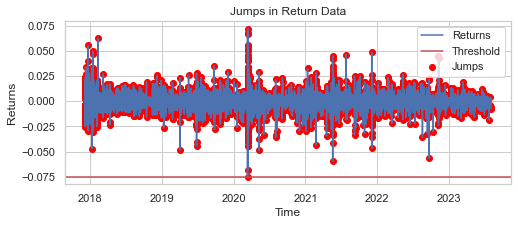

In [35]:
# Estimates the tail shape parameter using the POT method

# Step 1: Identify jumps in the data
def identify_jumps(returns, threshold_quantile):
    threshold = returns.quantile(threshold_quantile)
    jumps = returns[np.abs(returns) > threshold]
    return jumps

# Step 2: Fit GPD to the jumps
def fit_gpd(jumps):
    # Fit the GPD to the exceedances
    params = genpareto.fit(jumps - min(jumps))
    return params

# Step 3: Estimate shape parameter
def estimate_shape_parameter(jumps):
    params = fit_gpd(jumps)
    shape_parameter = params[0]  # Shape parameter is the first parameter in GPD
    return shape_parameter

jumps = identify_jumps(btc_min_return['return'], 0.99)
shape_parameter = estimate_shape_parameter(jumps)

print(f"Estimated Shape Parameter: {shape_parameter}")

# Plot the jumps and the threshold
plt.figure(figsize=(8, 3))
plt.plot(btc_min_return['return'], label='Returns')
plt.axhline(y=jumps.min(), color='r', linestyle='-', label='Threshold')
plt.scatter(jumps.index, jumps, color='red', label='Jumps')
plt.title('Jumps in Return Data')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [36]:
btc_min_return_rpot = btc_min_return[['close', 'return',\
                        'logRV_t', 'logRV_t-w', 'logRV_t-m']].copy()

u_n = np.percentile(np.abs(btc_min_return_rpot['return']), 99)
lambda_threshold = u_n
btc_min_return_rpot['J_t'] = btc_min_return_rpot['return']\
                              .apply(lambda x: x if abs(x) >= lambda_threshold else 0)
btc_min_return_rpot['Delta_J_plus_t'] = btc_min_return_rpot['return']\
                              .apply(lambda x: x**2 if x >= lambda_threshold else 0)
btc_min_return_rpot['Delta_J_minus_t'] = btc_min_return_rpot['return']\
                              .apply(lambda x: x**2 if x <= -lambda_threshold else 0)
btc_min_return_rpot['log1+J_t'] = np.log(1 + btc_min_return_rpot['J_t'])
btc_min_return_rpot['log1+Delta_J_plus_t'] = np.log(1 + btc_min_return_rpot['Delta_J_plus_t'])
btc_min_return_rpot['log1+Delta_J_minus_t'] = np.log(1 + btc_min_return_rpot['Delta_J_minus_t'])
btc_min_return_rpot['l_t'] = - btc_min_return_rpot['return']

In [39]:
# Compute jump tail shape parameter
window_size = 4 * 5 * 24 * 60
shape_params = []

for i in range(len(btc_min_return_rpot)):
    # Only compute for non-zero J_t
    if btc_min_return_rpot['J_t'].iloc[i] != 0:
        start_idx = max(0, i - window_size + 1)
        jumps_window = btc_min_return_rpot['J_t'].iloc[start_idx:i + 1]
        
        if not jumps_window.empty:
            params = genpareto.fit(jumps_window[jumps_window != 0])
            shape_param = params[0]  
        else:
            shape_param = np.nan
    else:
        shape_param = np.nan
    shape_params.append(shape_param)
    
btc_min_return_rpot['Xi_J'] = shape_params  
btc_min_return_rpot['Xi_J'].replace([np.inf, -np.inf], np.nan, inplace=True)
btc_min_return_rpot['Xi_J'] = np.where(btc_min_return_rpot['Xi_J'] < 0, 1e-10, btc_min_return_rpot['Xi_J'])
btc_min_return_rpot['log1+Xi_J'] = np.log(1 + btc_min_return_rpot['Xi_J'])
RM_prime = btc_min_return_rpot['log1+Xi_J'].values  
RM = btc_min_return_rpot[['logRV_t', 'logRV_t-w', 'logRV_t-m', 
                          'log1+J_t', 'log1+Delta_J_plus_t', 'log1+Delta_J_minus_t']].values
u_t = np.percentile(np.abs(btc_min_return_rpot['return'].values), 99) 

In [40]:
# Compute jump tail shape parameter
jumps_window = btc_min_return_rpot['J_t'][btc_min_return_rpot['J_t'] != 0]
params = genpareto.fit(jumps_window)
shape_param = params[0] if params else np.nan
Xi_J_full = shape_param

# Compute exceedance probability 
lambda_threshold = btc_min_return['return'].quantile(0.01)

feature_columns = ['logRV_t', 'logRV_t-w', 'logRV_t-m', 
                   'log1+J_t', 'log1+Delta_J_plus_t', 'log1+Delta_J_minus_t']

X = btc_min_return_rpot[feature_columns]
X = sm.add_constant(X)  # Adds the intercept term (psi_0)
y = (btc_min_return_rpot['return'] < lambda_threshold).astype(int)  # Binary outcome variable

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit_regularized(method='l1', disp=False)
hat_psi = result.params

In [41]:
# Compute jump tail shape and tail scale parameters

# Perform OLS regression to get initial values for kappa
btc_min_return_rpot_reduced = btc_min_return_rpot[btc_min_return_rpot['log1+J_t'] !=0]
X = btc_min_return_rpot[['logRV_t', 'logRV_t-w', 'logRV_t-m', 
                         'log1+J_t', 'log1+Delta_J_plus_t', 'log1+Delta_J_minus_t']]
X = sm.add_constant(X)
pca = PCA(n_components=7)  
X_pca = pca.fit_transform(X)[:-1]
y = btc_min_return_rpot['logRV_t'].shift(-1).dropna()
ridge_model = Ridge(alpha=0.1)  # Adjust regularization strength (alpha) as needed
ridge_model.fit(X_pca, y)
ridge_coefs = ridge_model.coef_
print("Coefficients:", ridge_model.coef_)
print("Intercept:", ridge_model.intercept_)
print("R-squared:", ridge_model.score(X_pca, y))
#initial_kappa = ols_model.params.values  # OLS estimates for kappa
initial_kappa = ridge_model.coef_
initial_nu = [0.0, 0.0]  # As specified
initial_guess = np.concatenate((initial_nu, initial_kappa))
# Define bounds for nu and kappa parameters
confidence_interval = 3  # Adjust this as necessary
bounds = [(param - confidence_interval, param + confidence_interval) for param in initial_guess]
bounds

Coefficients: [ 0.69899457 -0.36739983 -0.61373061  0.14013323  0.14470275  0.03221959
  0.        ]
Intercept: -6.9514131299272135
R-squared: 0.9999703648777983


[(-3.0, 3.0),
 (-3.0, 3.0),
 (-2.301005429256541, 3.698994570743459),
 (-3.3673998328562877, 2.6326001671437123),
 (-3.613730610370128, 2.386269389629872),
 (-2.8598667726546196, 3.1401332273453804),
 (-2.8552972458347736, 3.1447027541652264),
 (-2.9677804054806742, 3.0322195945193258),
 (-3.0, 3.0)]

In [48]:
btc_min_return_rpot['l_t'] = - btc_min_return_rpot['return'] 
l_t = btc_min_return_rpot['l_t'].values
def Log_Likelihood(params, RM_prime, RM, l, u):
    nu = params[:2]  # Parameters for nu
    kappa = params[2:]  # Parameters for kappa
    
    try:
        # Compute tail shape (xi) and tail scale (beta)
        xi = np.exp(nu[0] + nu[1] * RM_prime)
        beta = np.exp(kappa[0] + np.sum(kappa[1:] * RM, axis=1))
        
        # Compute log likelihood
        pdf_values = genpareto.pdf(-l - u, xi, loc=u, scale=beta / xi)
        valid_pdf_values = np.where(pdf_values > 0, pdf_values, np.finfo(float).eps)
        log_likelihood_value = np.mean(l *np.log(valid_pdf_values))
        
        return -log_likelihood_value
    except Exception as e:
        print(f"Error in log_likelihood: {e}")
        return np.inf


result = differential_evolution(
    Log_Likelihood,
    bounds=bounds,
    args=(RM_prime, RM, l_t, u_t),
    strategy='best1bin',  
    maxiter=100,  # Increase the number of iterations
    popsize=20,  # Increase the population size
    tol=1e-5,  # Tighter convergence tolerance
    atol=1e-5,  # Absolute tolerance for convergence
    seed=42,  # Keep the seed for reproducibility
    x0=list(initial_guess)
)

# Extract the optimal parameters
optimal_params = result.x
hat_nu = optimal_params[:2]
hat_kappa = optimal_params[2:]

print("Optimal nu:", hat_nu)
print("Optimal kappa:", hat_kappa)

Optimal nu: [-2.99645217 -0.32989173]
Optimal kappa: [-2.2710667   2.6299398   2.37665366  3.13708473 -2.43768562 -0.6698085
  1.15946716]


In [49]:
# Function to compute logit inverse
def logit_inverse(x):
    return 1 / (1 + np.exp(-x))

# Calculate phi_hat
def compute_phi_hat(psi_hat, btc_min_return_rpot):
    # Use the t-1 day data by shifting the columns
    logRV_t = btc_min_return_rpot['logRV_t']
    logRV_t_w = btc_min_return_rpot['logRV_t-w']
    logRV_t_m = btc_min_return_rpot['logRV_t-m']
    log1_J_t = btc_min_return_rpot['log1+J_t']
    log1_Delta_J_plus_t = btc_min_return_rpot['log1+Delta_J_plus_t']
    log1_Delta_J_minus_t = btc_min_return_rpot['log1+Delta_J_minus_t']
    
    logit_phi = (psi_hat['const'] + psi_hat['logRV_t'] * logRV_t +
                 psi_hat['logRV_t-w'] * logRV_t_w + psi_hat['logRV_t-m'] * logRV_t_m +
                 psi_hat['log1+J_t'] * log1_J_t + psi_hat['log1+Delta_J_plus_t'] * log1_Delta_J_plus_t +
                 psi_hat['log1+Delta_J_minus_t'] * log1_Delta_J_minus_t)
    
    phi_hat = logit_inverse(logit_phi)
    return phi_hat.shift(1)

# Calculate xi_hat
def compute_xi_hat(nu_hat, btc_min_return_rpot):
    # Use the t-1 day data by shifting the columns
    log1_Xi_J = btc_min_return_rpot['log1+Xi_J'].fillna(0)
    
    xi_hat = np.exp(nu_hat[0] + nu_hat[1] * log1_Xi_J)
    return xi_hat.shift(1)

# Calculate beta_hat
def compute_beta_hat(kappa_hat, btc_min_return_rpot):
    # Use the t-1 day data by shifting the columns
    logRV_t = btc_min_return_rpot['logRV_t']
    logRV_t_w = btc_min_return_rpot['logRV_t-w']
    logRV_t_m = btc_min_return_rpot['logRV_t-m']
    log1_J_t = btc_min_return_rpot['log1+J_t']
    log1_Delta_J_plus_t = btc_min_return_rpot['log1+Delta_J_plus_t']
    log1_Delta_J_minus_t = btc_min_return_rpot['log1+Delta_J_minus_t']
    
    beta_hat = np.exp(kappa_hat[0] + kappa_hat[1] * logRV_t +
                      kappa_hat[2] * logRV_t_w + kappa_hat[3] * logRV_t_m +
                      kappa_hat[4] * log1_J_t + kappa_hat[5] * log1_Delta_J_plus_t +
                      kappa_hat[6] * log1_Delta_J_minus_t)
    return beta_hat.shift(1)

# Assuming hat_psi, hat_nu, hat_kappa have been computed as per the provided code
phi_hat = compute_phi_hat(hat_psi, btc_min_return_rpot)
xi_hat = compute_xi_hat(hat_nu, btc_min_return_rpot)
beta_hat = compute_beta_hat(hat_kappa, btc_min_return_rpot)

btc_min_return_rpot['phi_hat'] = phi_hat
btc_min_return_rpot['xi_hat'] = xi_hat
btc_min_return_rpot['beta_hat'] = beta_hat

In [50]:
btc_min_return_rpot

,close,return,logRV_t,logRV_t-w,logRV_t-m,J_t,Delta_J_plus_t,Delta_J_minus_t,log1+J_t,log1+Delta_J_plus_t,log1+Delta_J_minus_t,l_t,Xi_J,log1+Xi_J,phi_hat,xi_hat,beta_hat
timestamp,,,,,,,,,,,,,,,,,
2017-12-05 11:47:00,11669.99,9.413177e-04,-5.258534,-3.378299,0.180824,0.0,0.0,0.0,0.0,0.0,0.0,-9.413177e-04,NaN,NaN,NaN,NaN,NaN
2017-12-05 11:48:00,11668.00,-1.705374e-04,-5.258674,-3.381446,0.180824,0.0,0.0,0.0,0.0,0.0,0.0,1.705374e-04,NaN,NaN,0.019324,0.049964,5.847159e-11
2017-12-05 11:49:00,11668.00,0.000000e+00,-5.258932,-3.383266,0.180808,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000e+00,NaN,NaN,0.019314,0.049964,5.801456e-11
2017-12-05 11:50:00,11668.00,0.000000e+00,-5.260619,-3.383342,0.180791,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000e+00,NaN,NaN,0.019305,0.049964,5.772201e-11
2017-12-05 11:51:00,11667.99,-8.570453e-07,-5.265560,-3.383638,0.180791,0.0,0.0,0.0,0.0,0.0,0.0,8.570453e-07,NaN,NaN,0.019274,0.049964,5.745311e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01 13:15:00,28907.41,3.951325e-04,-8.446455,-7.560694,-3.106532,0.0,0.0,0.0,0.0,0.0,0.0,-3.951325e-04,NaN,NaN,0.000313,0.049964,2.134362e-23
2023-08-01 13:16:00,28908.53,3.874364e-05,-8.446448,-7.560701,-3.106533,0.0,0.0,0.0,0.0,0.0,0.0,-3.874364e-05,NaN,NaN,0.000314,0.049964,2.138523e-23
2023-08-01 13:17:00,28902.49,-2.089567e-04,-8.446330,-7.560648,-3.106548,0.0,0.0,0.0,0.0,0.0,0.0,2.089567e-04,NaN,NaN,0.000314,0.049964,2.138519e-23


In [51]:
alpha = 0.01
U = np.percentile(btc_min_return_rpot['return'], 1)

def compute_var(phi_hat, beta_hat, xi_hat, u, alpha):
    var = u + beta_hat * ((phi_hat / alpha) ** xi_hat - 1) / xi_hat
    return var

VaR = pd.Series(index=phi_hat.index)
for idx in VaR.index:
    if pd.isna(xi_hat.loc[idx]):
        VaR.loc[idx] = U
    else:
        VaR.loc[idx] = compute_var(phi_hat.loc[idx], beta_hat.loc[idx], xi_hat.loc[idx], U, alpha)
        
btc_min_return_rpot['VaR'] = VaR

In [52]:
btc_min_return_rpot['VaR']

timestamp
2017-12-05 11:47:00   -0.003265
2017-12-05 11:48:00   -0.003265
2017-12-05 11:49:00   -0.003265
2017-12-05 11:50:00   -0.003265
2017-12-05 11:51:00   -0.003265
                         ...   
2023-08-01 13:15:00   -0.003265
2023-08-01 13:16:00   -0.003265
2023-08-01 13:17:00   -0.003265
2023-08-01 13:18:00   -0.003265
2023-08-01 13:19:00   -0.003265
Name: VaR, Length: 2965528, dtype: float64

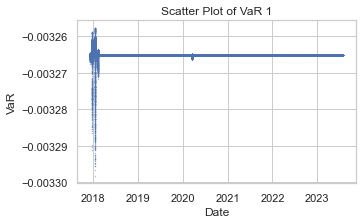

In [53]:
var_less_than_1 = btc_min_return_rpot[np.abs(btc_min_return_rpot['VaR']) < 1]

# Scatter plot
plt.figure(figsize=(5, 3))
plt.scatter(var_less_than_1.index, var_less_than_1['VaR'], color='b', marker='o', s=.1, alpha=0.75)
plt.title('Scatter Plot of VaR 1')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.grid(True)

plt.show()

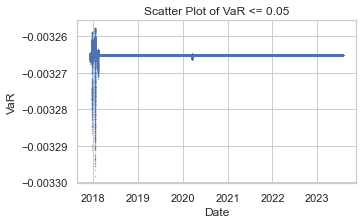

In [54]:
var_less_than_1 = btc_min_return_rpot[np.abs(btc_min_return_rpot['VaR']) <= 0.05]

# Scatter plot
plt.figure(figsize=(5, 3))
plt.scatter(var_less_than_1.index, var_less_than_1['VaR'], color='b', marker='o', s=.1, alpha=0.75)
plt.title('Scatter Plot of VaR <= 0.05')

plt.xlabel('Date')
plt.ylabel('VaR')
plt.grid(True)
plt.show()

In [ ]:
total_points = len(btc_min_return_rpot['VaR'].dropna())

# Calculate number of VaR points greater than 1
var_greater_than_1 = btc_min_return_rpot[np.abs(btc_min_return_rpot['VaR']) > .001].copy()  # Make a copy to avoid warnings
num_var_greater_than_1 = len(var_greater_than_1)

# Calculate proportion of VaR points greater than 1
proportion_greater_than_1 = num_var_greater_than_1 / total_points

# Calculate distribution of points greater than 1 across years using .loc to avoid warning
var_greater_than_1.loc[:, 'Year'] = var_greater_than_1.index.year
yearly_distribution = var_greater_than_1['Year'].value_counts().sort_index()


# Print results
print(f"Total number of VaR points: {total_points}")
print(f"Number of VaR points greater than .01: {num_var_greater_than_1}")
print(f"Proportion of VaR points greater than .01: {proportion_greater_than_1:.2%}")

# Plotting the bar plot
plt.figure(figsize=(5, 3))
yearly_distribution.plot(kind='bar', color='b')
plt.title('Distribution of VaR Points > 1 Across Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluation of model performance

# VaR backtesting: compare the actual loeese during extreme events with the Var estimates provided by the model

btc_min_return_rpot['exceeds_VaR'] = np.abs(btc_min_return_rpot['return']) > np.abs(btc_min_return_rpot['VaR'])


num_violations = btc_min_return_rpot['exceeds_VaR'].sum()
total_obs = len(btc_min_return_rpot)
violation_rate = num_violations / total_obs

print(f"Number of violations: {num_violations}")
print(f"Violation rate (expected 1% for 99% VaR): {violation_rate}")
